In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans 
import folium
from geopy.geocoders import Nominatim
%matplotlib inline

In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readily available on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the New York dataset.

Once the data is in a structured format, you can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto.

Your submission will be a link to your Jupyter Notebook on your Github repository.

# Part 1 (*10 marks*)

For this assignment, you will be required to explore and cluster the neighborhoods in Toronto.

1.    Start by creating a new Notebook for this assignment.
1.    Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown below:
<img src="recursos/Screen-Shot-2018-06-18-at-7.17.57-PM.png" width="500">

## Get the content of the article of Wikipedia

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
req = requests.get(url)
html = "" if req.status_code != 200 else BeautifulSoup(req.text, "html.parser")
req.status_code

200

## Parse the content in table and store in a dict called ``datos``

In [3]:
columnas = [s.text.strip() for s in html.table.tbody.tr.find_all('th')]
datos = {j:[] for j, columna in enumerate(columnas)}
for i, tr in enumerate(html.table.tbody.find_all('tr')):
    if i > 0:
        for j, s in enumerate(tr.find_all('td')):
            datos[j].append(s.text.strip())
for j, columna in enumerate(columnas):
    datos[columna] = datos.pop(j)
len(datos[columna]), datos.keys()

(289, dict_keys(['Postcode', 'Borough', 'Neighbourhood']))

## Create a ``DataFrame`` called ``df`` passing to him the dict ``datos``

In [4]:
df = pd.DataFrame(datos)
print(df.shape)
df.head(10)

(289, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


<img src="recursos/Screen-Shot-2018-06-18-at-7.17.57-PM.png" width="500">

3. To create the above dataframe:

    *    The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
    *    Only process the cells that have an assigned borough. Ignore cells with a borough that is **Not assigned**.
    *    More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that **M5A** is listed twice and has two neighborhoods: **Harbourfront** and **Regent Park**. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in **row 11** in the above table.

    *    If a cell has a borough but a **Not assigned** neighborhood, then the neighborhood will be the same as the borough. So for the **9th cell** in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be **Queen's Park**.
    *    Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
    *    In the last cell of your notebook, use the **.shape** method to print the number of rows of your dataframe.

### The dataframe will consist of three columns: ``PostalCode``, ``Borough``, and ``Neighborhood``

In [5]:
df.columns

Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')

### Only process the cells that have an assigned borough. 

Ignore cells with a borough that is **Not assigned**.

In [6]:
df = df[(df.Borough != 'Not assigned')]
print(df.shape)
df.head(3)

(212, 3)


,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 

So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.

In [7]:
condiciones = (df.Borough != 'Not assigned') & (df.Neighbourhood == 'Not assigned')
df.Neighbourhood[condiciones] = df.Borough[condiciones]
print(df.shape)
df.head(10)

(212, 3)


,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


### More than one neighborhood can exist in one postal code area.

For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

#### group the data by the ``Postcode`` value

In [8]:
d = {}
for index in df.index:
    k = df.at[index, 'Postcode']
    valor = df.at[index, 'Neighbourhood']
    if k not in d:
        d[k] = [df.at[index, 'Borough'], [valor,]]
    else:
        d[k][1].append(valor)
len(d)

103

#### rows will be combined into one row with the neighborhoods separated with a comma

In [9]:
for k in d:
    d[k][1] = ", ".join(d[k][1])

#### store all data in a ``list`` of ``list``s, except the columns

In [10]:
d_2 = []
for k in d:
    d_2.append([
        k,
        d[k][0],
        d[k][1]
    ])

#### create a DataFrame with the data and columns

In [11]:
df = pd.DataFrame(d_2, columns=columnas)
print(df.shape)
df.head()

(103, 3)


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


### In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [12]:
df.shape[0]

103

4. Submit a link to your Notebook on your Github repository. (**10 marks**)

**Note**: There are different website scraping libraries and packages in Python. One of the most common packages is BeautifulSoup. Here is the package's main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/

The package is so popular that there is a plethora of tutorials and examples of how to use it. Here is a very good Youtube video on how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k

Use the BeautifulSoup package or any other way you are comfortable with to transform the data in the table on the Wikipedia page into the above pandas dataframe

# Part 2 (*2 marks*)

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In an older version of this course, we were leveraging the Google Maps Geocoding API to get the latitude and the longitude coordinates of each neighborhood. However, recently Google started charging for their API: http://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike/, so we will use the Geocoder Python package instead: https://geocoder.readthedocs.io/index.html.

The problem with this Package is you have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So you can make a call to get the latitude and longitude coordinates of a given postal code and the result would be None, and then make the call again and you would get the coordinates. So, in order to make sure that you get the coordinates for all of our neighborhoods, you can run a while loop for each postal code. Taking postal code M5G as an example, your code would look something like this:

```python
import geocoder # import geocoder

# initialize your variable to None
lat_lng_coords = None

# loop until you get the coordinates
while(lat_lng_coords is None):
  g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
  lat_lng_coords = g.latlng

latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]
```

Given that this package can be very unreliable, in case you are not able to get the geographical coordinates of the neighborhoods using the Geocoder package, here is a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

Use the Geocoder package or the csv file to create the following dataframe:

<img src="recursos/Screen-Shot-2018-06-18-at-7.18.16-PM.png" width="600">

**Important Note**: There is a limit on how many times you can call geocoder.google function. It is 2500 times per day. This should be way more than enough for you to get acquainted with the package and to use it to get the geographical coordinates of the neighborhoods in the Toronto.

Once you are able to create the above dataframe, submit a link to the new Notebook on your Github repository. (**2 marks**)

## load geospatial coordinates from the file ``Geospatial_Coordinates.csv``

In [13]:
geocodes_df = pd.read_csv('recursos/Geospatial_Coordinates.csv')
print(geocodes_df.shape)
geocodes_df.head()

(103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## merge the data in new DataFrame called ``geo_df``, using ``Postalcode`` as the key to use in the merge

In [14]:
df_aux = df.copy(deep=True).sort_values(by='Postcode')

In [15]:
geocodes_df.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
geocodes_df.columns

Index(['Postcode', 'Latitude', 'Longitude'], dtype='object')

In [16]:
geo_df = df_aux.merge(geocodes_df, left_on='Postcode', right_on='Postcode')
print(geo_df.shape)
geo_df.head()

(103, 5)


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Part 3 (*3 marks*)

Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

Just make sure:

1.    to add enough Markdown cells to explain what you decided to do and to report any observations you make.
1.    to generate maps to visualize your neighborhoods and how they cluster together. 

Once you are happy with your analysis, submit a link to the new Notebook on your Github repository. (**3 marks**)

## show the set of values in ``Borough`` column

In [17]:
geo_df.Borough.unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       "Queen's Park", 'Mississauga', 'Etobicoke'], dtype=object)

## filter the values of ``Borough`` column contains keyword ``Toronto``

In [18]:
geo_df = geo_df[geo_df.Borough.str.contains('Toronto')].reset_index(drop=True)
print(geo_df.Borough.unique())
print(geo_df.shape)
geo_df.head()

['East Toronto' 'Central Toronto' 'Downtown Toronto' 'West Toronto']
(38, 5)


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


## prepare data for visualization and clustering

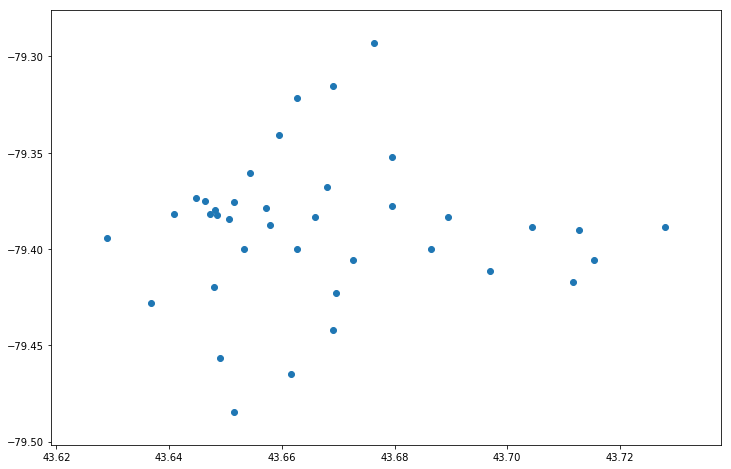

In [19]:
X = geo_df[['Latitude', 'Longitude']].get_values()
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1])

## clustering with KMeans

In [20]:
k_means = KMeans(init="k-means++", n_clusters=4, n_init=12, random_state=0)

In [21]:
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [22]:
k_means_labels = k_means.labels_
k_means_labels

array([0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 0])

In [23]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[ 43.66943648, -79.32465436],
       [ 43.65434514, -79.38272671],
       [ 43.70563855, -79.39811351],
       [ 43.65506566, -79.44547176]])

## visualize Toronto data with centroids

### In a 2D plot

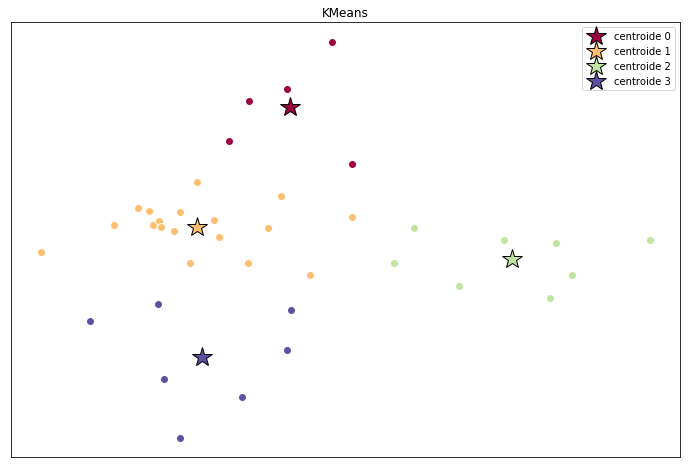

In [24]:
# initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(12, 8))

# colors uses a color map, which will produce an array of colors based on
# the number of labels. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# create a plot
ax = fig.add_subplot(1, 1, 1)

# loop through the data and plot the datapoints and centroids.
# k will range from 0-3, which will match the number of clusters in the dataset.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):

    # create a list of all datapoints, where the datapoitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # plot the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', 
            markerfacecolor=col, marker='o', markersize=8)
    
    # plot the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', 
            label='centroide '+str(k),
            markerfacecolor=col, marker='*', markeredgecolor='k', markersize=20)

# title of the plot
ax.set_title('KMeans')

# remove x-axis ticks
ax.set_xticks(())

# remove y-axis ticks
ax.set_yticks(())

plt.legend()

# show the plot
plt.show()

### In a map: Create a map of Toronto with neighborhoods superimposed on top.

#### Get latitude and longitude of Toronto

In [25]:
#address = 'Manhattan, NY'
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### creating a copy of ``geo_df`` DataFrame, and drop column ``Postcode``

In [26]:
neighborhoods = geo_df.drop(columns='Postcode')
neighborhoods.head()

,Borough,Neighbourhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790


#### visualize borough & neighborhood in a map using ``folium``

Clearly, there is a cluster nearby close to the beach

In [27]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
    #    parse_html=False
    ).add_to(map_toronto)  
    
map_toronto